# Digital EMG Signal Processing and Segmentation

Import packages.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import numpy as np
from filter import BandpassFilter1D, NotchFilter1D
from processing import MeanShift1D, Detrend1D, Resample1D, Normalize1D
from segment import Segment1D, Segment2D
from visualize import plot_signal1d, plot_signalnd
%matplotlib inline

### 1. Single-channel EMG Processing

Before processing multi-channel EMG signal data, we try with single-channel signal first. The signal-channel EMG signal (mV) are collected from one electrode with sampling rate of 1000Hz. Then signal samples are recorded to *.csv file. In this section, we load single-channel signal from *.csv file and visualize them.

In [2]:
# load emg signal from csv file
emg_raw = pd.read_csv('./data/example/emg1.csv')

# print first ten EMG samples
print('EMG samples:\n', emg_raw.head(10))

# print number of samples
print('\nNumber of samples:\n', len(emg_raw))

# get signal samples from channel 1
emg_raw = emg_raw['CH1']

EMG samples:
       CH1
0  1874.0
1  1874.0
2  1872.0
3  1872.0
4  1872.0
5  1865.0
6  1860.0
7  1874.0
8  1867.0
9  1859.0

Number of samples:
 60100


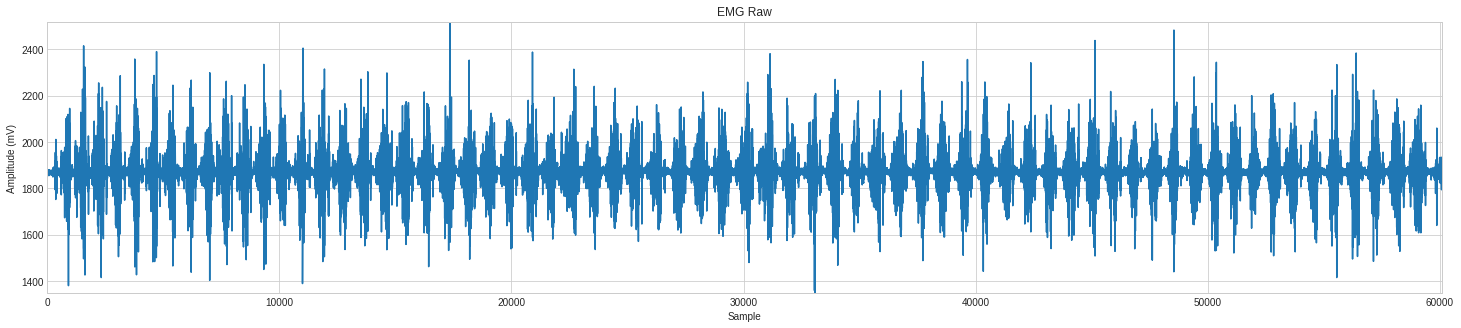

In [3]:
# visual signal
plot_signal1d(emg_raw, title='EMG Raw')

#### Step 0: Mean-correction

Before doing processing, the EMG signal should be removed the offset from zero due to the EMG signal posses both negative and positive values.

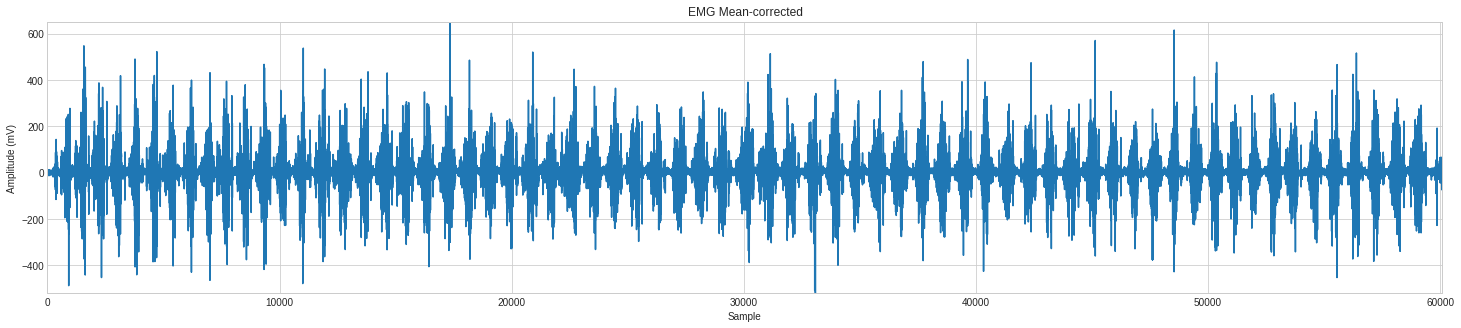

In [4]:
# mean-shift the signal
emg_raw = MeanShift1D.apply(emg_raw)

# visualize filtered signal
plot_signal1d(emg_raw, title='EMG Mean-corrected')

#### Step 1: Noise Filtering

EMG signal should always be recorded by analog band-pass filter because analog filter acts as an anti-aliasing filter. This means that the filter prevents aliasing by prevent aliasing (distortion) by high frequency, and non-EMG signal from being recorded. However, EMG can be aliased and sampled by analog-to-digital converter, leading the unwanted noise being introduced in the signal. To deal with such noise, digital band-passed filter and notch filter are applied again.

##### Bandpass filter

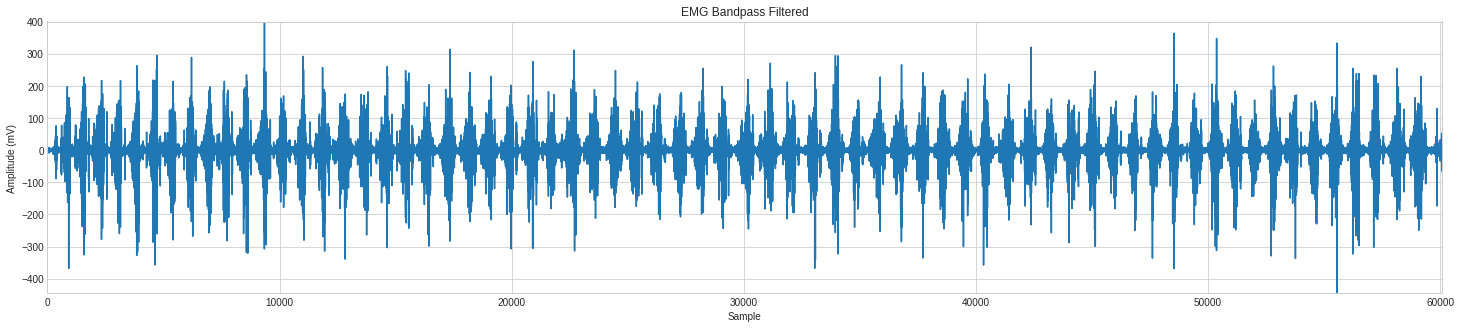

In [5]:
raw_fs = 1000   # original frequency
lowcut = 10      # low cutoff frequency
highcut = 200   # high cutoff frequency
emg_filtered = BandpassFilter1D.apply(emg_raw, lowcut, highcut, order=5, fs=raw_fs)

# visualize filtered signal
plot_signal1d(emg_filtered, title='EMG Bandpass Filtered')

##### Notch filter

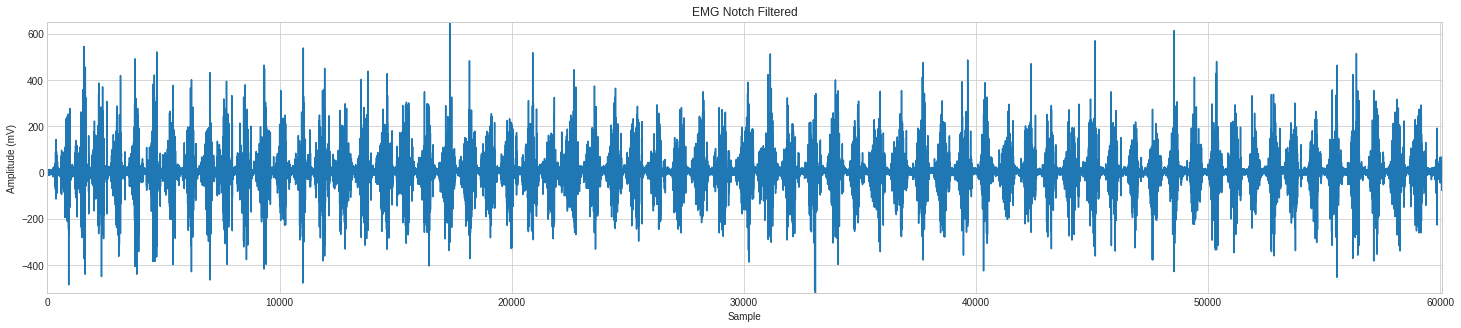

In [6]:
notchcut = 60   # notch cutoff frequency
Q = 20          # Q factor
emg_filtered = NotchFilter1D.apply(emg_raw, notchcut, Q, fs=raw_fs)

# visualize filtered signal
plot_signal1d(emg_filtered, title='EMG Notch Filtered')

#### Step 2: Detrend and Resampling

##### Detrend

Detrend aims to subtract offsets or trends from time-domain input-output data, making the output pattern become more stable.

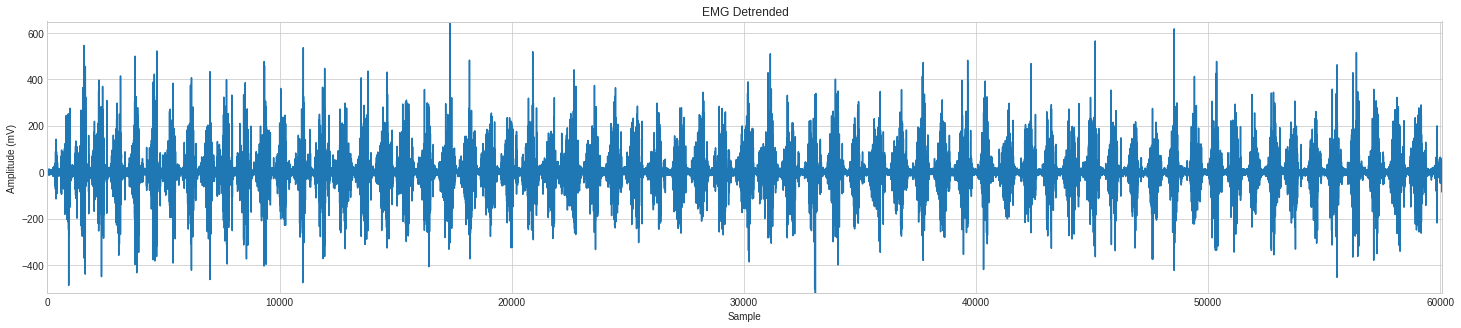

In [7]:
# detrend signal
window_size = 200   # window size
step_size = 50      # step size
emg_detrended = Detrend1D.apply(emg_filtered, detrend_type='locreg', window_size=window_size, step_size=step_size)

# visualize detrended signal
plot_signal1d(emg_detrended, title='EMG Detrended')

##### Resampling

To reduce computational consume, resampling is needed. For EMG signal processing, the new sampling rate should not be less than 512 Hz.

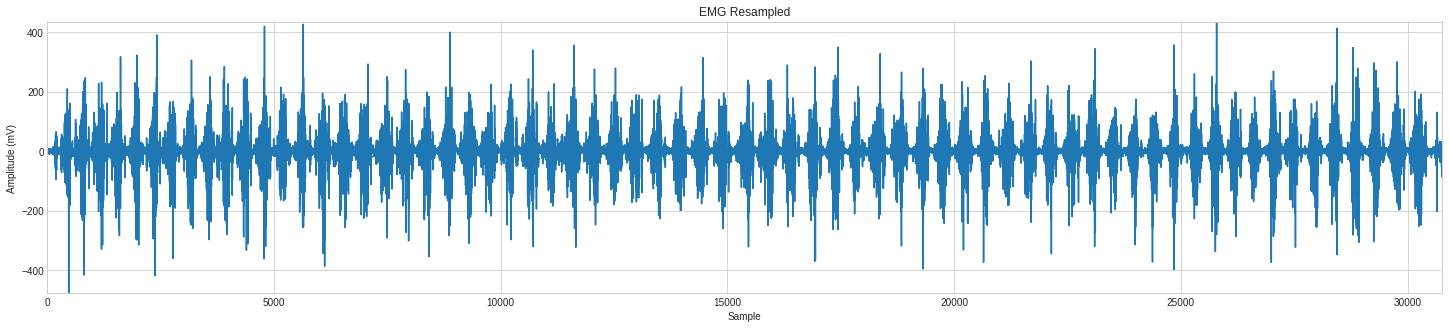

In [8]:
# resample the signal
target_fs = 512     # new frequency
emg_resampled = Resample1D.apply(emg_detrended, raw_fs=raw_fs, target_fs=target_fs)

# visualize resampled signal
plot_signal1d(emg_resampled, title='EMG Resampled')

##### Rectification

Signal rectification is an appropriate processing step to identify the overall strength of the neural drive to the muscle and is correlated with the strength of muscle contraction and its output.

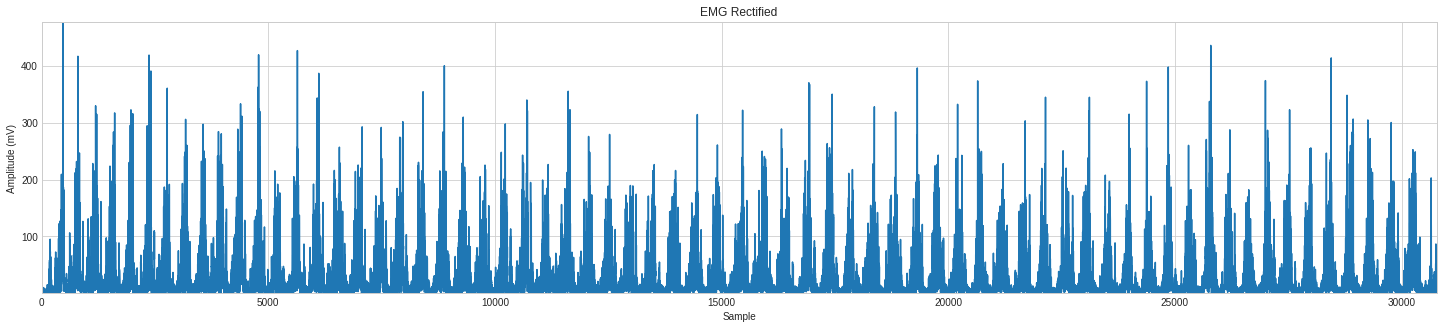

In [9]:
emg_rectified = abs(emg_resampled)

# visualize rectified signal
plot_signal1d(emg_rectified, title='EMG Rectified')

#### Step 3: Normalization

The signal should be normalized under uniform distribution for convenient computation. The two common methods are min-max normalization and mean-std normalization (standardization). In this demo, we normalize the signal by min-max method, the value range is normalized into [0, 1].

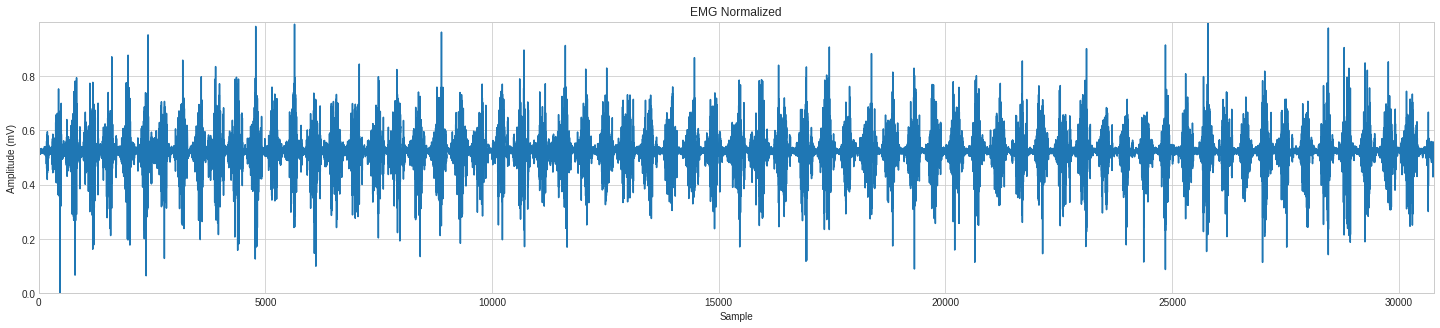

In [10]:
# normalize the signal
emg_normed = Normalize1D.apply(emg_resampled, norm_type='min_max')

# visualize normalized signal
plot_signal1d(emg_normed, title='EMG Normalized')

### 2. Multi-channel EMG Signal Processing

In previous section, we got the idea to process the single-channel collected digital EMG signal. In practical, the EMG signals are generally recorded in multi-channel to obtain more information further tasks, such as action analysis, machine control, etc.

In [11]:
# load multi-channel EMG signal
emg_raw = pd.read_csv('./data/example/emg2.csv')

# print first ten EMG samples
print('EMG samples:\n', emg_raw.head(10))

# print number of samples
num_samples = len(emg_raw)
print('\nNumber of samples:\n', num_samples)

# print number of channels
num_channels = len(emg_raw.columns)
print('Number of channels: \n', num_channels)

# get emg signal from 4 channels
emg_raw = emg_raw.values

EMG samples:
    727.0  725.0  724.0  726.0
0  736.0  733.0  737.0  735.0
1  737.0  735.0  743.0  739.0
2  738.0  738.0  749.0  741.0
3  739.0  739.0  749.0  736.0
4  737.0  735.0  740.0  730.0
5  734.0  730.0  735.0  727.0
6  732.0  729.0  730.0  725.0
7  731.0  725.0  726.0  723.0
8  724.0  720.0  720.0  714.0
9  721.0  718.0  716.0  713.0

Number of samples:
 9999
Number of channels: 
 4


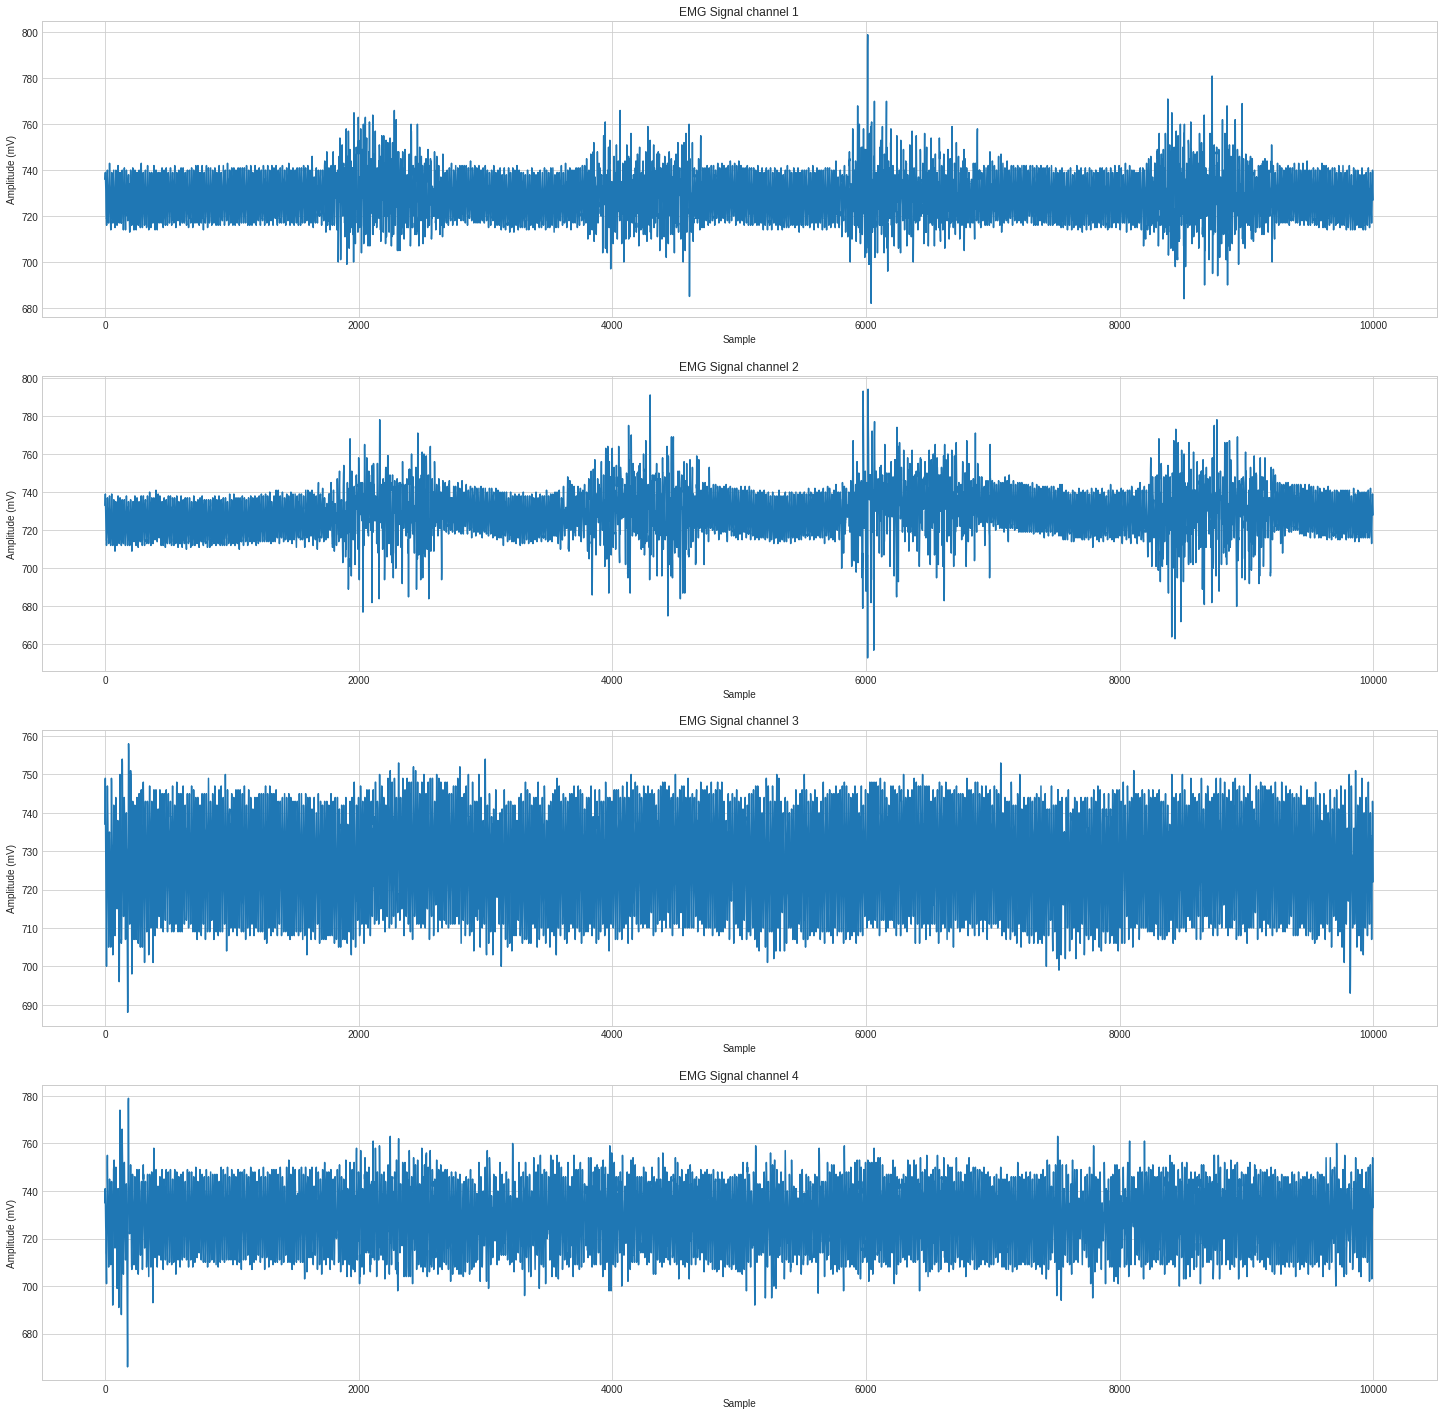

In [12]:
# visualize signal
plot_signalnd(emg_raw, title='EMG Signal')

To processing multi-channel EMG signal, we apply processing steps on signal of each channel. Based on single-channel processing steps explained in previous section, we wrap these steps into a function.

In [13]:
# process signal of each channel
def process_signal1d(x, raw_fs=1000, low_fs=1, high_fs=120, notch_fs=60, Q=20, windows=250, step_size=50, target_fs=512,):
    """
    @param x: signal of a single channel
    @param raw_fs: original sampling rate
    @param low_fs: low cutoff frequency
    @param high_fs: high cutoff frequency
    @param notch_fs: notch cutoff frequency
    @param Q: Q factor
    @param windows: windows size for detrending
    @param step_size: step size for detrending
    @param target_fs: target sampling rate for resampling step
    """
    # mean-correct signal
    x_processed = MeanShift1D.apply(x)
    # filtering noise
    x_processed = BandpassFilter1D.apply(x_processed, low_fs, high_fs, order=4, fs=raw_fs)
    x_processed = NotchFilter1D.apply(x_processed, notch_fs, Q=Q, fs=raw_fs)
    # detrend
    x_processed = Detrend1D.apply(x_processed, detrend_type='locreg', window_size=windows, step_size=step_size)
    # resample
    x_processed = Resample1D.apply(x_processed, raw_fs, target_fs)
    # rectify
    x_processed = abs(x_processed)
    # normalize
    x_processed = Normalize1D.apply(x_processed, norm_type='min_max')
    return x_processed

Processing 4-channel EMG signal

In [14]:
# define processing parameters
raw_fs = 1000
target_fs = 512
low_fs = 10
high_fs = 120
notch_fs = 60
Q = 20
windows = 500
steps = 50
# process each channel
emg_processed = []
for i in range(num_channels):
    signal_processed = process_signal1d(emg_raw[:, i], raw_fs, low_fs, high_fs, notch_fs, Q, windows, steps, target_fs)
    emg_processed.append(signal_processed)
# convert emg signal to numpy matrix
emg_processed = np.array(emg_processed)

Visualize processed 4-channel EMG signal

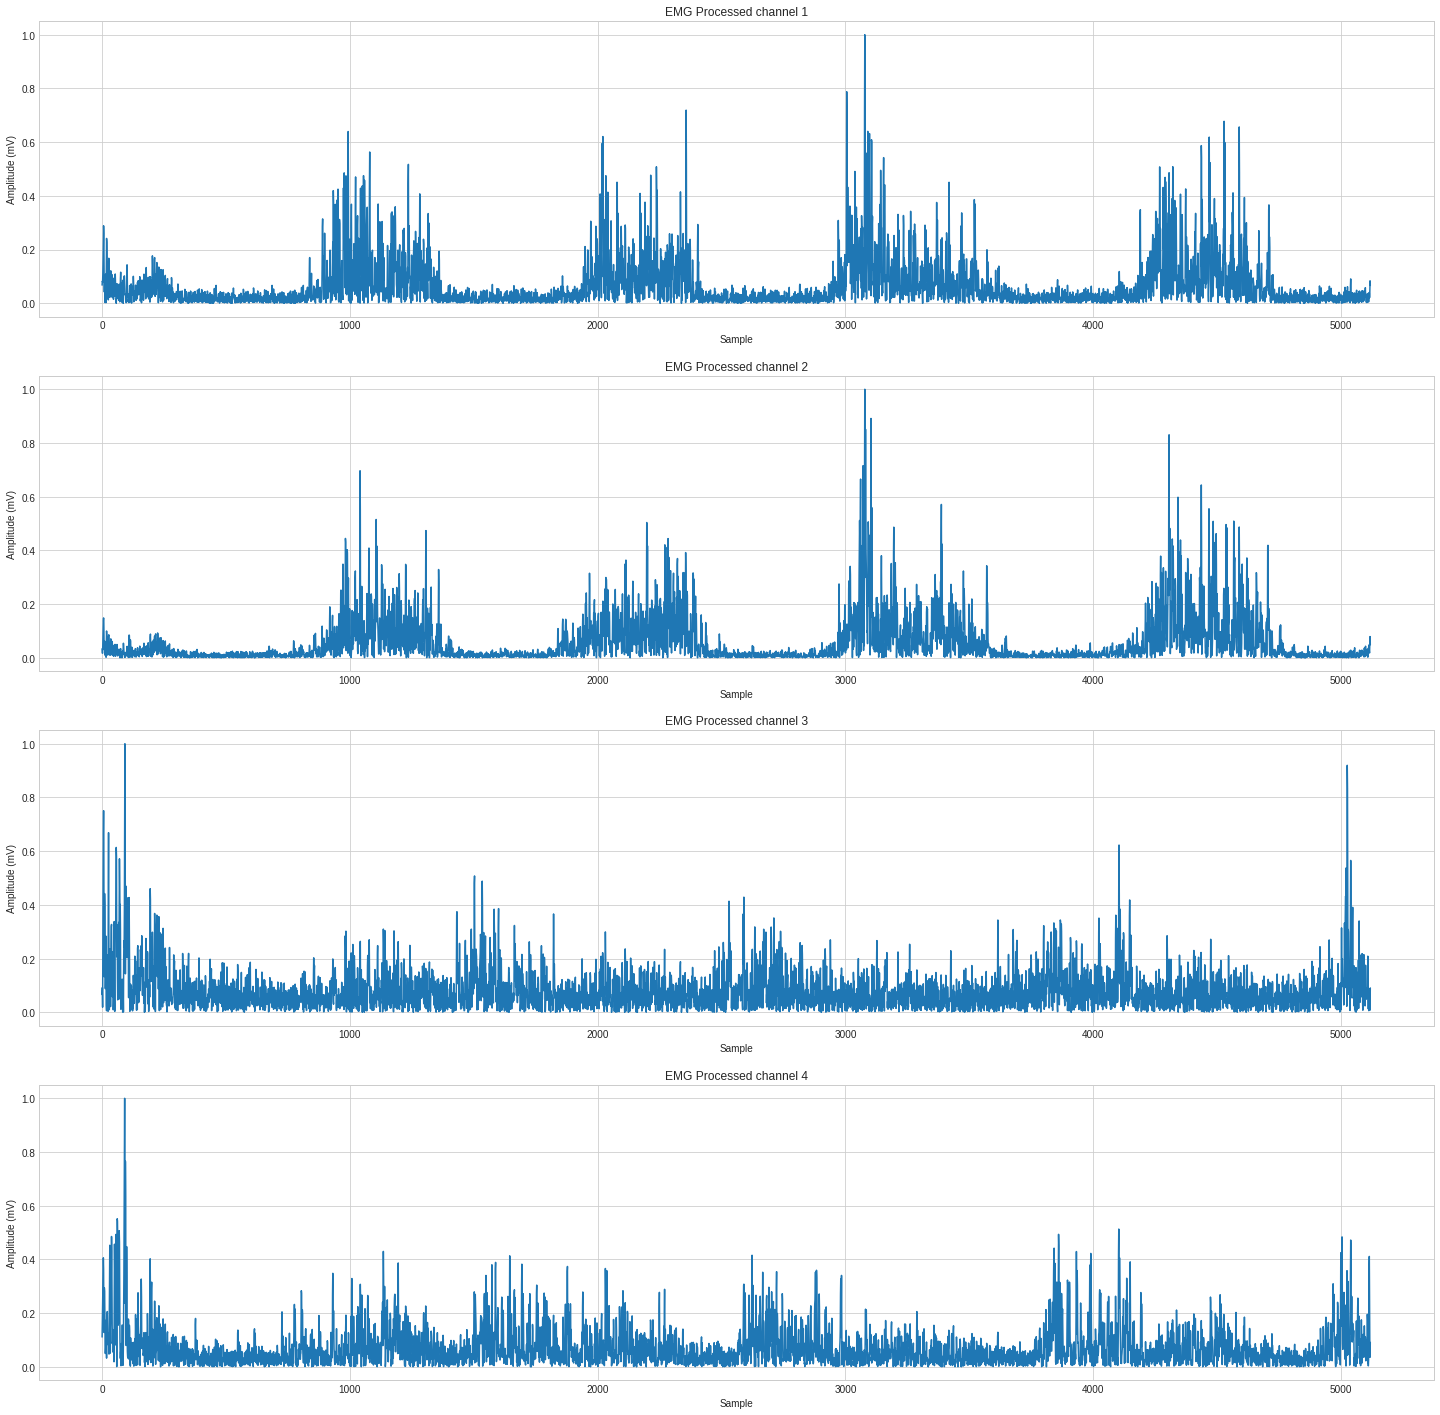

In [15]:
plot_signalnd(emg_processed.T, title='EMG Processed')

## Part 2: EMG Signal Segmentation

In this part, we perform single-channel EMG signal segmentation at first.

Segment channel-1 EMG signal.

In [17]:
segments_1d = Segment1D.apply(emg_processed[0, :], window_size=250, step_size=50)

print('Number of segments:\n', len(segments_1d))

print('\nSize of a segment:\n', len(segments_1d[0]))

Number of segments:
 105

Size of a segment:
 250


Visualize a segment

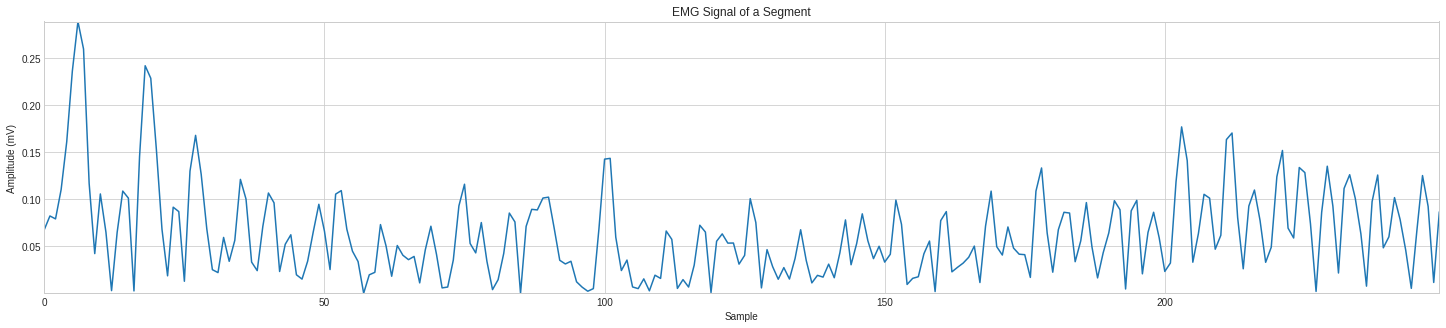

In [18]:
plot_signal1d(segments_1d[0], title='EMG Signal of a Segment')

For multi-channel EMG signal, we perform the segmentation in each channel.

Segment 4-channel clean signal.

In [20]:
segments = Segment2D.apply(emg_processed, window_size=250, step_size=50)

Visualize a 4-channel signal segment.

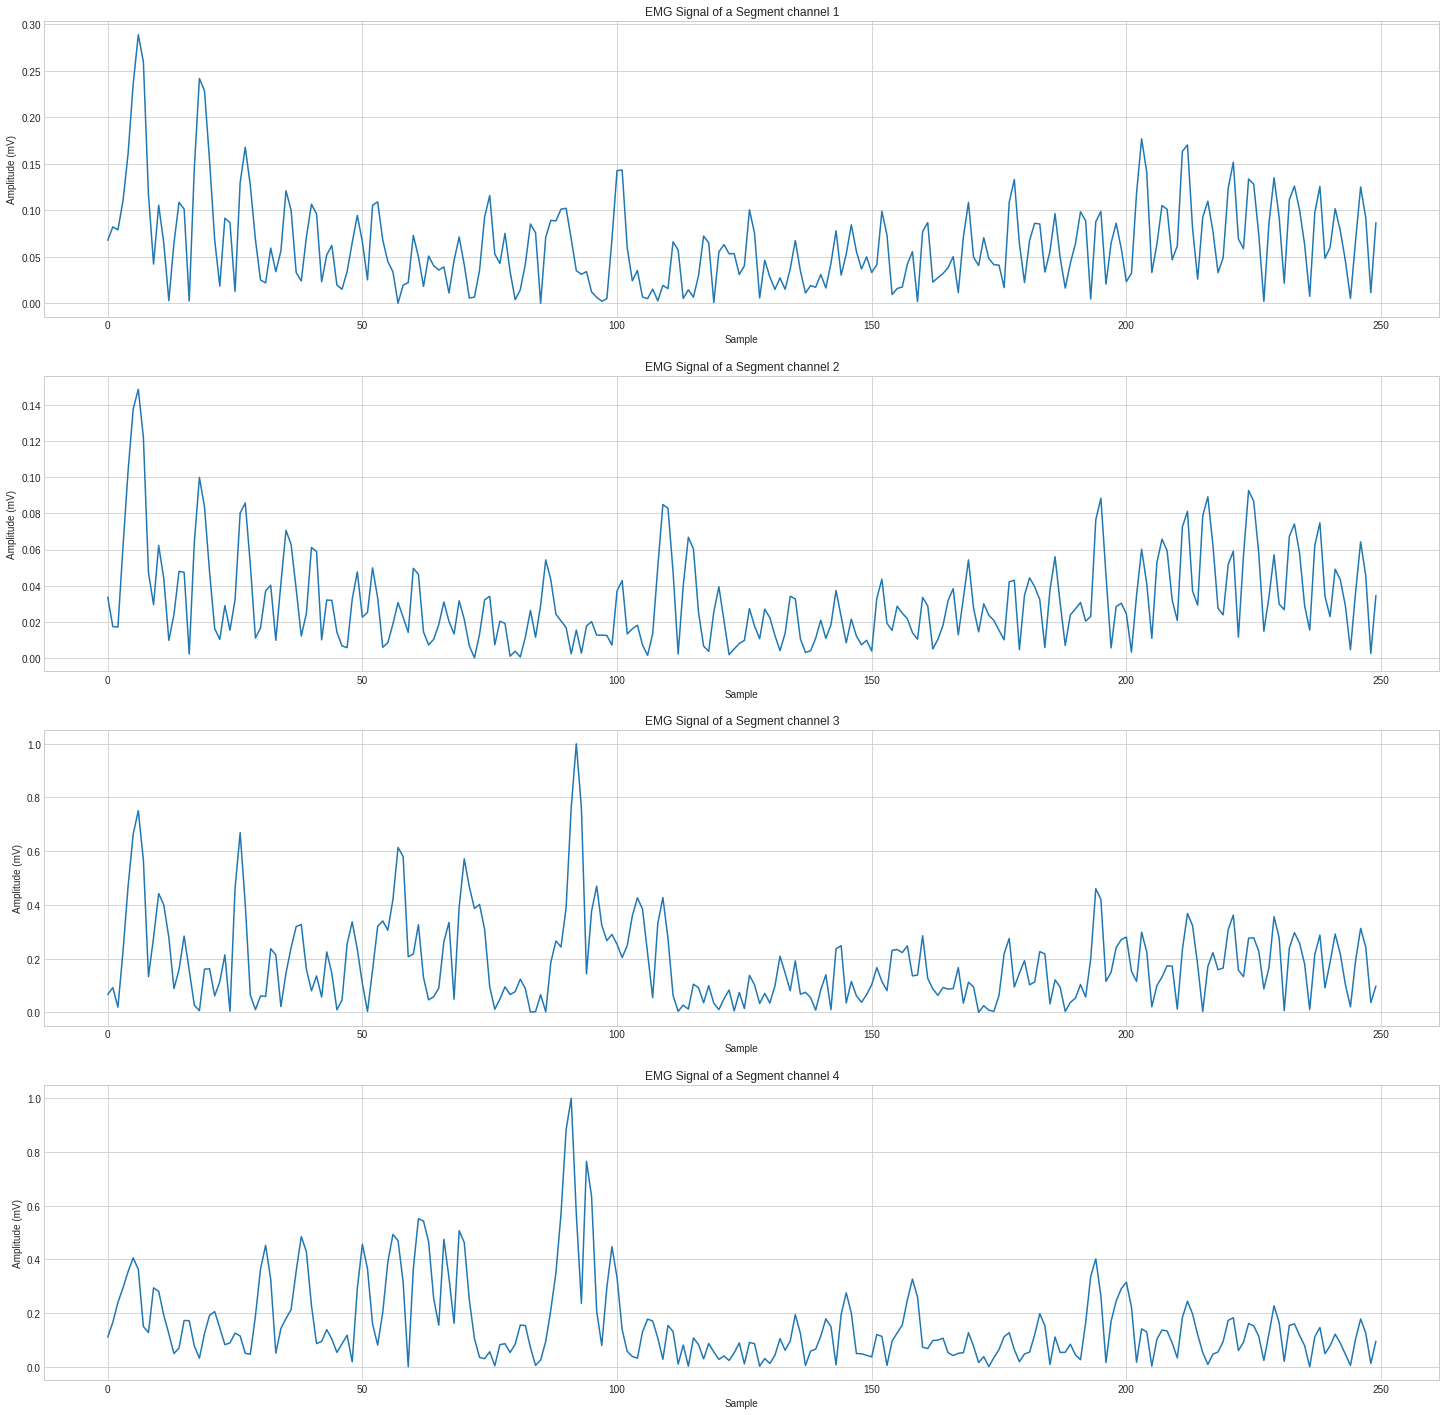

In [21]:
plot_signalnd(segments[0].T, title='EMG Signal of a Segment')

## Practices

### Practice 1:

Try to process single-channel EMG signal in ``data/single-channel``. Find appropriate cutoff frequency for noise filtering, window size and step size for detrending to clean the given signal and suitable segment window size.

### Practice 2:

Try to process multi-channel EMG signal in ``data/multi-channel``. Find appropriate cutoff frequency for noise filtering, window size and step size for detrending to clean the given signal and suitable segment window size.

## References

* P. Konrad (2006).
[The ABC of EMG – A practical introduction to kinesiological electromyography](http://www.noraxon.com/wp-content/uploads/2014/12/ABC-EMG-ISBN.pdf).
Noraxon USA Inc.
* E. J. Rechy-Ramirez,  H. Hu (2011).
[Stages for Developing Control Systems using EMG and EEG Signals: A survey](https://core.ac.uk/download/pdf/74372522.pdf?fbclid=IwAR1yHxcnkma-JPlsvmG-P7reZr3_oJlX7egWxArn4XX5ogzLdK3Ad1TRfAY).
* F. Zhang, S. Chen, H. Zhang, X. Zhang, G. Li (2014).
[Bioelectric signal detrending using smoothness prior approach](https://pubmed.ncbi.nlm.nih.gov/24894030/).
* H. Zhang, M. Zhao, C. Wei, D. Mantini, Z. Li & Q. Liu. (2020).
[EEGdenoiseNet: A benchmark dataset for deep learning solutions of EEG denoising](https://arxiv.org/pdf/2009.11662).
* NeuralKit2:
[https://github.com/neuropsychology/NeuroKit](https://github.com/neuropsychology/NeuroKit).